<a href="https://colab.research.google.com/github/kevinajordan/emo_rec/blob/master/AffectiveMemory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download emotion recogntion repo
Install and import software dependencies


In [1]:
# download repo
!git clone https://github.com/kevinajordan/emo_rec.git

Cloning into 'emo_rec'...
remote: Enumerating objects: 33919, done.
remote: Total 33919 (delta 0), reused 0 (delta 0), pack-reused 33919
Receiving objects: 100% (33919/33919), 152.16 MiB | 25.76 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Checking out files: 100% (35746/35746), done.


In [2]:
# join the split fer2013 tar files
!cat emo_rec/fer2013.tar.00* > fer2013.tar

In [3]:
!tar -xvf "/content/fer2013.tar"

fer2013.csv


In [1]:
import os
os.chdir('emo_rec/FERPlus/src')

In [5]:
!cp "/content/fer2013.csv" ../

In [ ]:
# Uncomment below if the images need to be re-generated.
#!python generate_training_data.py -d '../data' -fer '../fer2013.csv' -ferplus '../fer2013new.csv'

## Curating Images and Labels from AWS Labeling Job
s3 labelled image location: https://console.aws.amazon.com/s3/buckets/mldata.tailoredlabs.org/emotion-labeling-job/emotion-labeling/?region=us-east-1

In [ ]:
import json
import os

import boto3
import pandas as pd

In [ ]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('mldata.tailoredlabs.org')

In [ ]:
bucket.download_file("emotion-labeling-job/emotion-labeling/manifests/output/output.manifest", "/labels.manifest")

NoCredentialsError: ignored

In [ ]:
labeled_images = []
with open("/labels.manifest") as manifest:
  for line in manifest.readlines():
    data = json.loads(line)
    class_name = data.get('emotion-labeling-metadata', {}).get('class-name', None)
    if class_name:
      labeled_images.append({
          'image': os.path.basename(data['source-ref']),
          "label": class_name
      })


In [ ]:
labeled_images_df = pd.DataFrame(labeled_images, columns=["image", "label"])

In [ ]:
os.chdir('/content/emo_rec/')

In [ ]:
os.mkdir('labeling_job')

In [ ]:
os.chdir('labeling_job')

In [ ]:
labeled_images_df.to_csv("labels.csv")

In [ ]:
os.mkdir('images')

In [ ]:
from tqdm import tqdm

In [ ]:
with tqdm(total=len(labeled_images_df)) as pbar:
  for index, row in labeled_images_df.iterrows():
    pbar.update()
    bucket.download_file(row['image'], os.path.join("images", row['image']))

100%|██████████| 5097/5097 [05:18<00:00, 16.02it/s]


## Dataset Building

In [2]:
%tensorflow_version 2.x

In [3]:
import tensorflow as tf
import tensorflow.keras as keras

In [4]:
from PIL import Image
import numpy as np
import pandas as pd
import cv2, dlib, sys, csv
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input, Activation, BatchNormalization, Conv2D, MaxPool2D, Dense, Dropout, Flatten
from keras.optimizers import  Adamax
from keras.callbacks import ModelCheckpoint,  EarlyStopping , ReduceLROnPlateau
from sklearn.metrics import r2_score
import numpy, copy
from ferplus import *

In [5]:
# FERPlus code is found here: https://github.com/microsoft/FERPlus/tree/master/src
emotion_table = {'neutral'  : 0, 
                 'happiness': 1, 
                 'surprise' : 2, 
                 'sadness'  : 3, 
                 'anger'    : 4, 
                 'disgust'  : 5, 
                 'fear'     : 6, 
                 'contempt' : 7}
    
# List of folders for training, validation and test.
train_folders = ['/content/emo_rec/FERPlus/data/FER2013Train']
valid_folders = ['/content/emo_rec/FERPlus/data/FER2013Valid'] 
test_folders  = ['/content/emo_rec/FERPlus/data/FER2013Test']
num_classes = len(emotion_table)

# read FER+ dataset.
# logging.info("Loading data...")
train_params        = FERPlusParameters(num_classes, 48, 48, "crossentropy", shuffle=True)
test_and_val_params = FERPlusParameters(num_classes, 48, 48, "crossentropy", shuffle=True)

# ferplus.py holds FERPlusReader.create() which calls load_folders() which calls _process_data()
train_data_reader   = FERPlusReader.create('/content/emo_rec/FERPlus/data', train_folders, "label.csv", train_params)
val_data_reader     = FERPlusReader.create('/content/emo_rec/FERPlus/data', valid_folders, "label.csv", test_and_val_params)
test_data_reader    = FERPlusReader.create('/content/emo_rec/FERPlus/data', test_folders, "label.csv", test_and_val_params)

# Forms dataset
train_size = train_data_reader.size()
train_images, train_labels, train_batch_size = train_data_reader.next_minibatch(train_size)
val_size = val_data_reader.size()
val_images, val_labels, val_batch_size = val_data_reader.next_minibatch(val_size)
test_size = test_data_reader.size()
test_images, test_labels, test_batch_size = test_data_reader.next_minibatch(test_size)

In [ ]:
train_labels

array([[0.4      , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.6      , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.6      , 0.       , 0.4      , ..., 0.       , 0.       ,
        0.       ],
       [0.6666667, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [1.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [6]:
import logging
def display_summary(train_data_reader, val_data_reader, test_data_reader):
    '''
    Summarize the data in a tabular format.
    '''
    emotion_count = train_data_reader.emotion_count
    emotin_header = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']

    logging.info("{0}\t{1}\t{2}\t{3}".format("".ljust(10), "Train", "Val", "Test"))
    for index in range(emotion_count):
        print("{0}\t{1}\t{2}\t{3}".format(emotin_header[index].ljust(10), 
                     train_data_reader.per_emotion_count[index], 
                     val_data_reader.per_emotion_count[index], 
                     test_data_reader.per_emotion_count[index]))

In [7]:
display_summary(train_data_reader, val_data_reader, test_data_reader)

neutral   	10107	1311	1250
happiness 	7501	897	925
surprise  	3517	452	438
sadness   	3445	406	437
anger     	2401	319	315
disgust   	170	29	20
fear      	643	69	96
contempt  	163	25	26


## Form Pandas Data Set

WIP: Something may be wrong with the labels....don't know for sure

In [8]:
# create pandas dataframes for training, validation, and testing datasets
train_df = pd.DataFrame({'images': list(train_images), 'labels': list(train_labels)})
val_df = pd.DataFrame({'images': list(val_images), 'labels': list(val_labels)})
test_df = pd.DataFrame({'images': list(test_images), 'labels': list(test_labels)})

# expand labels into their own columns
train_df[['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']] = pd.DataFrame(train_df.labels.values.tolist(), index=train_df.index)
val_df[['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']] = pd.DataFrame(val_df.labels.values.tolist(), index=val_df.index)
test_df[['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']] = pd.DataFrame(test_df.labels.values.tolist(), index=test_df.index)

# Convert to numpy arrays with 2 dimensions - (samples, # of classes)
train_labels = np.array(train_df[['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']].values.tolist())
val_labels = np.array(val_df[['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']].values.tolist())
test_labels = np.array(test_df[['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']].values.tolist())

# converts the images column back to a 4-dimensional numpy array or tensor.
train_images = train_df['images'].to_numpy()
train_images = np.concatenate(train_images).astype(None)
train_images = np.expand_dims(train_images, axis=1)
val_images = val_df['images'].to_numpy()
val_images = np.concatenate(val_images).astype(None)
val_images = np.expand_dims(val_images, axis=1)
test_images = test_df['images'].to_numpy()
test_images = np.concatenate(test_images).astype(None)
test_images = np.expand_dims(test_images, axis=1)

# Change the shape to channels last
train_images = train_images.reshape((len(train_images),48,48,1))
val_images = val_images.reshape((len(val_images), 48, 48,1))
test_images = test_images.reshape((len(test_images), 48, 48,1))

In [ ]:
train_df.head()

,images,labels,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt
0,"[[[-0.25390092, -0.5557979, 0.16205914, 0.6604...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,"[[[-1.0670401, -0.92957485, -1.0004344, -1.069...","[0.71428573, 0.2857143, 0.0, 0.0, 0.0, 0.0, 0....",0.714286,0.285714,0.0,0.0,0.0,0.0,0.0,0.0
2,"[[[-1.9677047, -2.3091106, -2.2576487, -2.1868...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,"[[[-0.69153464, -1.028689, -1.6249278, -2.0496...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,"[[[-1.4051622, -0.91514343, 0.76111794, 1.4645...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Verifying the right shape
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

(27947, 48, 48, 1)
(3508, 48, 48, 1)
(3507, 48, 48, 1)


In [10]:
print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(27947, 8)
(3508, 8)
(3507, 8)


## Model Building and Training

In [16]:
os.mkdir('/content/models')

In [11]:
filepath= "/content/models/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', mode="min", patience=15)
reduce_lr = ReduceLROnPlateau(factor = 0.5, monitor='val_loss', min_lr = 1e-5, patience = 2)

### Model 1 - Uses TF 2

In [12]:
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')

In [13]:
inputShape = (48, 48, 1)
emotion_header = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']
numberOfOutputs = len(emotion_header)
nch = 256

inputLayer = Input(shape=inputShape)

#Conv1 and 2
conv1 = Conv2D(int(nch / 4), (3, 3), padding="same", data_format="channels_last", kernel_initializer="glorot_uniform", name="Vision_conv1")(inputLayer)
bn1 = BatchNormalization(axis = 1)(conv1)
actv1 = Activation("relu")(bn1)

conv2 = Conv2D(int(nch / 4), (3, 3), padding="same", data_format="channels_last", kernel_initializer="glorot_uniform", name="Vision_conv2")(actv1)
bn2 = BatchNormalization(axis = 1)(conv2)
actv2 = Activation("relu")(bn2)

mp1 = MaxPool2D(pool_size=(2, 2))(actv2)
drop1 = Dropout(0.35)(mp1)

#Conv 3 and 4
conv3 = Conv2D(int(nch / 2), (3, 3), padding="same",data_format="channels_last", kernel_initializer="glorot_uniform", name="Vision_conv3")(drop1)
bn3 = BatchNormalization(axis = 1)(conv3)
actv3 = Activation("relu")(bn3)

conv4 = Conv2D(int(nch / 2), (3, 3), padding="same",data_format="channels_last", kernel_initializer="glorot_uniform", name="Vision_conv4")(actv3)
bn4 = BatchNormalization(axis = 1)(conv4)
actv4 = Activation("relu")(bn4)

mp2 = MaxPool2D(pool_size=(2, 2))(actv4)
drop2 = Dropout(0.25)(mp2)

#Conv 5 and 6 and 7
conv5 = Conv2D(int(nch / 2), (3, 3), padding="same", data_format="channels_last", kernel_initializer="glorot_uniform", name="Vision_conv5")(drop2)
bn5 = BatchNormalization(axis = 1)(conv5)
actv5 = Activation("relu")(bn5)

conv6 = Conv2D(int(nch / 2), (3, 3), padding="same",data_format="channels_last", kernel_initializer="glorot_uniform", name="Vision_conv6")(actv5)
bn6 = BatchNormalization(axis = 1)(conv6)
actv6 = Activation("relu")(bn6)

conv7 = Conv2D(int(nch / 2), (3, 3), padding="same",data_format="channels_last", kernel_initializer="glorot_uniform", name="Vision_conv7")(actv6)
bn7 = BatchNormalization(axis = 1)(conv7)
actv7 = Activation("relu")(bn7)

mp3 = MaxPool2D(pool_size=(2, 2))(actv7)
drop3 = Dropout(0.25)(mp3)

#Conv 8 and 9 and 10
conv8 = Conv2D(nch, (3, 3), padding="same",data_format="channels_last", kernel_initializer="glorot_uniform", name="Vision_conv8")(drop3)
bn8 = BatchNormalization(axis = 1)(conv8)
actv8 = Activation("relu")(bn8)

conv9 = Conv2D(nch , (3, 3), padding="same", data_format="channels_last", kernel_initializer="glorot_uniform", name="conv9")(actv8)
bn9 = BatchNormalization(axis = 1)(conv9)
actv9 = Activation("relu")(bn9)

'''
conv10 = Conv2D(nch , (3, 3), padding="same", data_format="channels_first", kernel_initializer="glorot_uniform", activation="relu", name="conv10")(actv9)
bn10 = BatchNormalization(axis = 1)(conv10)
actv10 = Activation("relu")(bn10)
'''
mp4 = MaxPool2D(pool_size=(2, 2))(actv9)
drop4 = Dropout(0.25)(mp4)

# Fully Connected layers
flatten = Flatten()(drop4)

dense = Dense(200, activation="relu")(flatten)
drop5 = Dropout(0.25)(dense)

output = Dense(numberOfOutputs, activation="softmax")(drop5)
model = Model(inputs=inputLayer, outputs=output)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
Vision_conv1 (Conv2D)        (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        192       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
Vision_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        192       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)       

In [14]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(x=train_images, y=train_labels, epochs=150, batch_size=32, validation_data=(val_images, val_labels), callbacks=[checkpoint, reduce_lr, early_stopping])

Epoch 1/150
874/874 [==============================] - ETA: 0s - loss: 2.4580 - categorical_accuracy: 0.3338
Epoch 00001: val_categorical_accuracy improved from -inf to 0.37372, saving model to /content/models/weights.best.hdf5
874/874 [==============================] - 31s 36ms/step - loss: 2.4580 - categorical_accuracy: 0.3338 - val_loss: 1.6597 - val_categorical_accuracy: 0.3737
Epoch 2/150
873/874 [============================>.] - ETA: 0s - loss: 1.6714 - categorical_accuracy: 0.3595
Epoch 00002: val_categorical_accuracy did not improve from 0.37372
874/874 [==============================] - 30s 35ms/step - loss: 1.6714 - categorical_accuracy: 0.3596 - val_loss: 1.7279 - val_categorical_accuracy: 0.2822
Epoch 3/150
873/874 [============================>.] - ETA: 0s - loss: 1.6156 - categorical_accuracy: 0.3778
Epoch 00003: val_categorical_accuracy improved from 0.37372 to 0.44527, saving model to /content/models/weights.best.hdf5
874/874 [==============================] - 31s 36ms

In [15]:
loss, cat_acc = model.evaluate(x=test_images, y=test_labels, batch_size=32, verbose=0)
print('categorical accuracy: ',cat_acc)
print('loss: ',loss)

categorical accuracy:  0.7653264999389648
loss:  0.7844665050506592


### Saving Model

if using TF, saves in TensorFlow Serving format

if using Keras, saves to a h5 file which is in HD5F format


In [22]:
# Saves a model as a json file. Produces a folder structure with the model saved as 'saved_model.pb' 
# along with variables saved separately.
from datetime import date
import time
today = date.today().isoformat()
model.save('/content/'+ str(today)+'_' + str(round(cat_acc,2)) + '_model')

INFO:tensorflow:Assets written to: /content/2020-09-30_0.77_model/assets


INFO:tensorflow:Assets written to: /content/2020-09-30_0.77_model/assets


In [21]:
os.chdir('/content/')

## Model 2 - Uses TF 2

In [ ]:
input_l = Input(shape=(1,64,64))

conv1 = Conv2D(64, (3, 1), padding='same', input_shape=(1,64,64))(input_l)
conv1_2 = Conv2D(64, (1, 3), padding='same')(conv1)
bn1 = BatchNormalization()(conv1_2)
act1 = Activation('relu')(bn1)
mp1 = MaxPool2D(pool_size=(2, 2), strides=None, padding='same')(act1)
dp1 = Dropout(0.25)(mp1)

conv2 = Conv2D(128, (3, 1), padding='same')(dp1)
conv2_2 = Conv2D(128, (1, 3), padding='same')(conv2)
bn2 = BatchNormalization()(conv2_2)
act2 = Activation('relu')(bn2)
mp2 = MaxPool2D(pool_size=(2, 2), strides=None, padding='same')(act2)
dp2 = Dropout(0.25)(mp2)

conv3 = Conv2D(256, (3, 1), padding='same')(dp2)
conv3_2 = Conv2D(256, (1, 3), padding='same')(conv3)
bn3 = BatchNormalization()(conv3_2)
act3 = Activation('relu')(bn3)
mp3 = MaxPool2D(pool_size=(2, 2), strides=None, padding='same')(act3)
dp3 = Dropout(0.25)(mp2)

conv4 = Conv2D(512, (3, 1), padding='same')(dp3)
conv4_2 = Conv2D(512, (1, 3), padding='same')(conv2)
bn4 = BatchNormalization()(conv4_2)
act4 = Activation('relu')(bn4)
mp4 = MaxPool2D(pool_size=(2, 2), strides=None, padding='same')(act4)
dp4 = Dropout(0.25)(mp4)

flat = Flatten()(dp4)

dn = Dense(512)(flat)
bn5 = BatchNormalization()(dn)
act5 = Activation('relu')(bn5)
dp5 = Dropout(0.25)(act5)

dn2 = Dense(256)(dp5)
bn6 = BatchNormalization()(dn2)
act6 = Activation('relu')(bn6)
dp6 = Dropout(0.25)(act6)

output = Dense(5, activation="softmax")(dp6)

model2 = Model(inputs=input_l, outputs=output)
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 64, 64)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 1, 64, 64)         12352     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 1, 64, 64)         12352     
_________________________________________________________________
batch_normalization_10 (Batc (None, 1, 64, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 1, 64, 64)         0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 32, 64)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 32, 64)         0     

In [ ]:
model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model2.fit(x=train_images, y=train_labels, epochs=50, batch_size=32, validation_data=(val_images, val_labels), callbacks=[checkpoint, reduce_lr, early_stopping])

Epoch 1/50
759/759 [==============================] - ETA: 0s - loss: 1.4742 - categorical_accuracy: 0.4026
Epoch 00001: val_categorical_accuracy improved from -inf to 0.49482, saving model to /content/models/weights.best.hdf5
759/759 [==============================] - 6s 7ms/step - loss: 1.4742 - categorical_accuracy: 0.4026 - val_loss: 1.2733 - val_categorical_accuracy: 0.4948 - lr: 0.0010
Epoch 2/50
754/759 [============================>.] - ETA: 0s - loss: 1.3313 - categorical_accuracy: 0.4625
Epoch 00002: val_categorical_accuracy improved from 0.49482 to 0.55761, saving model to /content/models/weights.best.hdf5
759/759 [==============================] - 5s 7ms/step - loss: 1.3314 - categorical_accuracy: 0.4623 - val_loss: 1.1640 - val_categorical_accuracy: 0.5576 - lr: 0.0010
Epoch 3/50
757/759 [============================>.] - ETA: 0s - loss: 1.2616 - categorical_accuracy: 0.4974
Epoch 00003: val_categorical_accuracy improved from 0.55761 to 0.56634, saving model to /content/mo

## Evaluating Performance - WIP
* confusion matrix
* [F-beta score for Keras](https://www.kaggle.com/arsenyinfo/f-beta-score-for-keras)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
%load_ext tensorboard

In [ ]:
%time
preds = model.predict(test_images)

In [ ]:
preds.shape

(3020, 5)

In [ ]:
test_labels.shape

(3020, 5)

In [ ]:
con_mat = tf.math.confusion_matrix(labels=tf.argmax(test_labels, 1), predictions=tf.argmax(preds, 1))

In [ ]:
con_mat

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[950.,  35.,  14.,  70.,  14.],
       [ 28., 825.,  15.,  14.,  10.],
       [ 30.,  14., 341.,   5.,   4.],
       [103.,  20.,   2., 238.,  19.],
       [ 32.,  19.,  20.,  12., 186.]], dtype=float32)>

In [ ]:
con_mat  = tf.cast(con_mat, dtype=tf.float32)

In [ ]:
con_mat_norm = np.around(con_mat / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

AttributeError: ignored

ERROR! Session/line number was not unique in database. History logging moved to new session 59


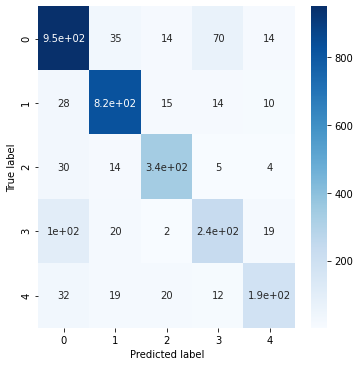

In [ ]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat, index = emotion_header, columns = emotion_header)

figure = plt.figure(figsize=(5, 5))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
from datetime import date
import time
today = date.today().isoformat()
model.save('/content/models/' + today + '_' + str(cat_acc) + '_model.h5')

In [ ]:
# Evaluate the restored model
loss, acc = model.evaluate(test_images,  test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

print(model.predict(test_images).shape)

3137/3137 - 3s - loss: 0.7238 - categorical_accuracy: 0.8180
Restored model, accuracy: 81.80%
(3137, 8)


## Performance Log:

mode: majority, epochs: 50, optimizer: Adam, acc: 0.8059, cat_acc: 0.8059

mode: majority, epochs: 37, optimizer: Adam, cat_acc: 0.8317

mode: crossentropy, epochs: 30, optimizer: Adam, acc: 0.7967, cat_acc: 0.7967


mode: probability, epochs: 50, optimizer: custom Adamax, acc: 0.747, cat_acc: 0.747

mode: probability, epochs: 150, optimizer: Adam, cat_acc: 0.763 - stopped after 38 epochs.

#### New preprocessing with dlib.
-----------------------------
mode: majority, epochs: 50, optimizer: Adam, cat_acc: 0.8180, stopped after 42 epochs

#### Without shunting inhibition -
10 layers - mode: majority, epochs: 30, optimizer: Adam, cat_acc: 82.67, loss: 77.12

### Channels Last
10 layers - mode: majority, epochs: 35, optimizer: Adam, cat_acc: 80.89, loss: 63.9

10 layers - mode: majority, epochs: 36, optimizer: Adam, cat_acc: 79.05, loss: 69.19

## Hyperas - Hyper Parameter Tuning

In [ ]:
!pip install hyperas hyperopt

In [ ]:
%tensorflow_version 2.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np
import pandas as pd
import cv2, dlib, sys, csv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Conv2D, MaxPool2D, Dense, Dropout, Flatten, Lambda
from tensorflow.keras.optimizers import  Adamax
from tensorflow.keras.callbacks import ModelCheckpoint,  EarlyStopping , ReduceLROnPlateau
from sklearn.metrics import r2_score
import numpy, copy
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')

In [ ]:
from ferplus import *

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Copy/download the file
fid = '1gp5CypE8qxaYSq_Bzy2j4kqiupzRrC_V'
f = drive.CreateFile({'id': fid})
f.GetContentFile('AffectiveMemory.ipynb')

In [ ]:
import hyperas, hyperopt
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

Using TensorFlow backend.


In [ ]:
def data():
    '''
    Data providing function:
    This function is separated from model() so that hyperopt
    won't reload data for each evaluation run.
    '''
    emotion_table = {'neutral'  : 0, 
                 'happiness': 1, 
                 'surprise' : 2, 
                 'sadness'  : 3, 
                 'anger'    : 4, 
                 'disgust'  : 5, 
                 'fear'     : 6, 
                 'contempt' : 7}
    
    # List of folders for training, validation and test.
    train_folders = ['/content/emo_rec/FERPlus/data/FER2013Train']
    valid_folders = ['/content/emo_rec/FERPlus/data/FER2013Valid'] 
    test_folders  = ['/content/emo_rec/FERPlus/data/FER2013Test']
    num_classes = len(emotion_table)

    # read FER+ dataset.
    #logging.info("Loading data...")
    train_params        = FERPlusParameters(num_classes, 96, 96, "majority", False)
    test_and_val_params = FERPlusParameters(num_classes, 96, 96, "majority", True)

    train_data_reader   = FERPlusReader.create('/content/emo_rec/FERPlus/data', train_folders, "label.csv", train_params)
    val_data_reader     = FERPlusReader.create('/content/emo_rec/FERPlus/data', valid_folders, "label.csv", test_and_val_params)
    test_data_reader    = FERPlusReader.create('/content/emo_rec/FERPlus/data', test_folders, "label.csv", test_and_val_params)
    emotion_count = train_data_reader.emotion_count
    emotion_header = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']
    
    # Forms dataset
    train_size = train_data_reader.size()
    train_images, train_labels, train_batch_size = train_data_reader.next_minibatch(train_size)
    val_size = val_data_reader.size()
    val_images, val_labels, val_batch_size = val_data_reader.next_minibatch(val_size)
    test_size = test_data_reader.size()
    test_images, test_labels, test_batch_size = test_data_reader.next_minibatch(test_size)

    return train_images, train_labels, test_images, test_labels

In [ ]:
def model(train_images, train_labels, test_images, test_labels):
  '''
  Model providing function:
  Create Keras model with double curly brackets dropped-in as needed.
  Return value has to be a valid python dictionary with two customary keys:
      - loss: Specify a numeric evaluation metric to be minimized
      - status: Just use STATUS_OK and see hyperopt documentation if not feasible
  The last one is optional, though recommended, namely:
      - model: specify the model just created so that we can later use it again.
  '''
  inputShape = (1, 96, 96)
  emotion_header = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']
  numberOfOutputs = len(emotion_header)
  nch = 256

  inputLayer = Input(shape=inputShape, batch_size=1)

  #Conv1 and 2
  conv1 = Conv2D(int(nch / 4), (3, 3), padding="same", data_format="channels_first", kernel_initializer="glorot_uniform", name="Vision_conv1")(inputLayer)
  bn1 = BatchNormalization(axis = 1)(conv1)
  actv1 = Activation("relu")(bn1)

  conv2 = Conv2D(int(nch / 4), (3, 3), padding="same", data_format="channels_first", kernel_initializer="glorot_uniform", name="Vision_conv2")(actv1)
  bn2 = BatchNormalization(axis = 1)(conv2)
  actv2 = Activation("relu")(bn2)

  mp1 = MaxPool2D(pool_size=(2, 2))(actv2)
  drop1 = Dropout(0.25)(mp1)

  #Conv 3 and 4
  conv3 = Conv2D(int(nch / 2), (3, 3), padding="same",data_format="channels_first", kernel_initializer="glorot_uniform", name="Vision_conv3")(drop1)
  bn3 = BatchNormalization(axis = 1)(conv3)
  actv3 = Activation("relu")(bn3)

  conv4 = Conv2D(int(nch / 2), (3, 3), padding="same",data_format="channels_first", kernel_initializer="glorot_uniform", name="Vision_conv4")(actv3)
  bn4 = BatchNormalization(axis = 1)(conv4)
  actv4 = Activation("relu")(bn4)

  mp2 = MaxPool2D(pool_size=(2, 2))(actv4)
  drop2 = Dropout(0.25)(mp2)

  #Conv 5 and 6 and 7
  conv5 = Conv2D(int(nch / 2), (3, 3), padding="same", data_format="channels_first", kernel_initializer="glorot_uniform", name="Vision_conv5")(drop2)
  bn5 = BatchNormalization(axis = 1)(conv5)
  actv5 = Activation("relu")(bn5)

  conv6 = Conv2D(int(nch / 2), (3, 3), padding="same",data_format="channels_first", kernel_initializer="glorot_uniform", name="Vision_conv6")(actv5)
  bn6 = BatchNormalization(axis = 1)(conv6)
  actv6 = Activation("relu")(bn6)

  conv7 = Conv2D(int(nch / 2), (3, 3), padding="same",data_format="channels_first", kernel_initializer="glorot_uniform", name="Vision_conv7")(actv6)
  bn7 = BatchNormalization(axis = 1)(conv7)
  actv7 = Activation("relu")(bn7)

  mp3 = MaxPool2D(pool_size=(2, 2))(actv7)
  drop3 = Dropout(0.25)(mp3)

  #Conv 8 and 9 and 10
  conv8 = Conv2D(nch, (3, 3), padding="same",data_format="channels_first", kernel_initializer="glorot_uniform", name="Vision_conv8")(drop3)
  bn8 = BatchNormalization(axis = 1)(conv8)
  actv8 = Activation("relu")(bn8)

  conv9 = Conv2D(nch , (3, 3), padding="same", data_format="channels_first", kernel_initializer="glorot_uniform", name="conv9")(actv8)
  bn9 = BatchNormalization(axis = 1)(conv9)
  actv9 = Activation("relu")(bn9)

  #conv10 = Conv2D(nch , (3, 3), padding="same", data_format="channels_first", kernel_initializer="glorot_uniform", activation="relu", name="conv10")(actv9)
  #bn10 = BatchNormalization(axis = 1)(conv10)
  #actv10 = Activation("relu")(bn10)
  #conv10 = Conv2D(nch , (3, 3), padding="same", data_format="channels_first", kernel_initializer="glorot_uniform", activation="relu", name="conv10")(actv9)
  #conv10_inhibition = Conv2D(nch, (3, 3), padding="same", data_format="channels_first", kernel_initializer="glorot_uniform", activation="relu", name="conv10_inhibition")(actv9)
  #v_conv_inhibitted = Lambda(function=shuntingInhibition)([conv10, conv10_inhibition])

  mp4 = MaxPool2D(pool_size=(2, 2))(actv9)
  drop4 = Dropout(0.25)(mp4)

  flatten = Flatten()(drop4)

  dense = Dense(200, activation="relu")(flatten)
  drop5 = Dropout(0.25)(dense)

  output = Dense(numberOfOutputs, activation="softmax")(drop5)
  model = Model(inputs=inputLayer, outputs=output)

  #filepath= "/content/models/weights.best.hdf5"
  #checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
  early_stopping = EarlyStopping(monitor='val_loss', mode="min", patience=15)
  reduce_lr = ReduceLROnPlateau(factor = 0.5, monitor='val_loss', min_lr = 1e-5, patience = 2)

  model.compile(optimizer={{choice(['Adam'])}}, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  model.fit(x=train_images, y=train_labels, epochs={{choice([50])}}, batch_size={{choice([32])}}, validation_data=(val_images, val_labels), callbacks=[reduce_lr, early_stopping])
  loss, cat_acc = model.evaluate(x=test_images, y=test_labels, batch_size=32, verbose=0)
  print('Test accuracy:', cat_acc)
  return {'loss': -cat_acc, 'status': STATUS_OK, 'model': model}

In [ ]:
best_run, best_model = optim.minimize(model=model,
                                          data=data,
                                          max_evals=10,
                                          algo=tpe.suggest,
                                          notebook_name='AffectiveMemory',
                                          trials=Trials(), return_space=True)

>>> Imports:
#coding=utf-8

try:
    import os
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from PIL import Image
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import cv2, dlib, sys, csv
except:
    pass

try:
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
except:
    pass

try:
    from tensorflow.keras.models import Model, load_model
except:
    pass

try:
    from tensorflow.keras.layers import Input, Activation, BatchNormalization, Conv2D, MaxPool2D, Dense, Dropout, Flatten, Lambda
except:
    pass

try:
    from tensorflow.keras.optimizers import Adamax
except:
    pass

try:
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
except:
    pass

try:
    from sklearn.metrics import r2_score
except:
    pass

try:
    import numpy, copy
except:
    pass

try:
    from tensorflow.keras import backend as K
except:


In [ ]:
os.mkdir('/content/models')

In [ ]:
optimizer = Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# Testing Models and Image Processing 
with keras, dlib, and cv2

## Converting To TF Lite

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

In [ ]:
!pwd

/content/emo_rec/FERPlus/src


In [ ]:
# loading tensorflow model. Can include .h5 file or folder path for a TF SavedModel format
model = keras.models.load_model("/content/keras_84_model.h5")

In [ ]:
# For Tensorflow Model conversion to TF Lite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir="/content/2020-09-290.79_model")

In [ ]:
tflite_model = converter.convert()

In [ ]:
open("converted_model.tflite", "wb").write(tflite_model)

In [21]:
# For Keras Model converstion to TF Lite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [ ]:
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmplq9w5t15/assets


In [ ]:
open("/content/keras_84_converted_model.tflite", "wb").write(tflite_model)

9638992

#### Loading TF Lite Model and Testing It

In [ ]:
interpreter = tf.lite.Interpreter(model_path="/content/converted_model.tflite")

In [ ]:
interpreter.allocate_tensors()

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
print(input_details)

[{'name': 'Vision_conv1_input', 'index': 0, 'shape': array([ 1, 64, 64,  1], dtype=int32), 'shape_signature': array([-1, 64, 64,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
input_shape = input_details[0]['shape']

In [ ]:
input_data = np.array(np.random.random_sample((1,64,64,1)), dtype=np.float32)

In [ ]:
print(input_data.shape)

(1, 64, 64, 1)


In [ ]:
#loading an image

In [ ]:
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

In [ ]:
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[0.8647858  0.03293163 0.00332822 0.09705164 0.00190269]]


## Lambda Preprocessing Functions

In [ ]:
import numpy as np
import cv2, dlib

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image

In [ ]:
class imageProcessor:
  '''
  Order of operations:
  - Detects Faces
  - Converts to grayscale
  - resizes image
  - converts float32 tensors
  - normalizes
  '''
  @property
  def faceDetector(self):
    return self._faceDetector

  def __init__(self):

    self._faceDetector = dlib.get_frontal_face_detector()

  def preProcess(self, image, imageSize):
    '''
    Grayscales, normalizes
    '''
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.array(cv2.resize(image, imageSize))
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32')
    image /= 255

    return image


  def detectFace(self, image):
    '''
    Detects face(s) in image and crops them out.
    '''

    #print ("CurrentFace:", self.currentFaceDetectionFrequency)
    dets = self.faceDetector(image, 1)
    face = []

    for k, d in enumerate(dets):
        face = image[d.top():d.bottom(), d.left():d.right()]
        break

    return dets, face

In [ ]:
def detectFace(image):
    '''
    Detects face(s) in image and crops them out.
    '''

    #print ("CurrentFace:", self.currentFaceDetectionFrequency)
    face_det = dlib.get_frontal_face_detector()
    dets = face_det(image, 1)
    face = []

    for k, d in enumerate(dets):
        face = image[d.top():d.bottom(), d.left():d.right()]
        break

    return dets, face

In [ ]:
'''loads image using opencv'''
def preProcess(image):
    '''
    Grayscales, normalizes
    '''
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.array(cv2.resize(image, (48,48)))
    image = image.reshape((1,48,48,1))
    image = image.astype('float32')
    image /= 255.

    return image

In [ ]:
'''loads image in the PIL format'''
def preProcess(image):
    '''
    Grayscales, normalizes
    '''
    img_tensor = image.img_to_array(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.array(cv2.resize(image, (64,64)))
    image = image.reshape((1,64,64,1))
    image = image.astype('float32')
    image /= 255.

    return image

In [ ]:
# loads image with OpenCV
image = cv2.imread('/content/dad_and_I.jpg')

In [ ]:
face_coords, face_img = detectFace(image)

In [ ]:
face = preProcess(face_img)

In [ ]:
face.shape

(1, 48, 48, 1)

In [ ]:
face_rs = np.resize(face, (64,64))

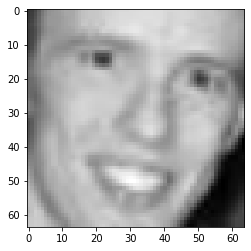

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(face_rs, cmap="gray")

##### Preprocessing with TensorFlow Keras Preprocessing Image

In [ ]:
'''load image with tf.keras.preprocessing.image'''
img = image.load_img('/content/dad_and_I.jpg', color_mode="grayscale", target_size=(64, 64))

AttributeError: ignored

In [ ]:
img_tensor = image.img_to_array(img)

In [ ]:
img_tensor = np.expand_dims(img_tensor, axis=0)

In [ ]:
img_tensor /= 255.

In [ ]:
img_tensor.shape

(64, 64)

## Loading and testing out the pre-trained model

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

In [ ]:
model = keras.models.load_model('/content/keras_84_model.h5')

In [ ]:
single_pred = model.predict(face)

In [ ]:
single_pred

array([[0.5400922 , 0.02619397, 0.03360386, 0.271906  , 0.09288889,
        0.01245457, 0.00689932, 0.01596121]], dtype=float32)

In [ ]:
np.argmax(single_pred)

0

# Image PreProcessing From FERPlus
rect_util.py and img_util.py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r /content/models/2020-07-11_0.8403973579406738_model /content/drive/My\ Drive

In [ ]:
'''
rect_util.py
'''
import math
  
class Point(object):
    def __init__(self, x=0.0, y=0.0):
        self.x = x
        self.y = y
     
    def __add__(self, p):
        """Point(x1+x2, y1+y2)"""
        return Point(self.x+p.x, self.y+p.y)
     
    def __sub__(self, p):
        """Point(x1-x2, y1-y2)"""
        return Point(self.x-p.x, self.y-p.y)
     
    def __mul__( self, scalar ):
        """Point(x1*x2, y1*y2)"""
        return Point(self.x*scalar, self.y*scalar)
     
    def __div__(self, scalar):
        """Point(x1/x2, y1/y2)"""
        return Point(self.x/scalar, self.y/scalar)
     
    def __str__(self):
        return "(%s, %s)" % (self.x, self.y)
     
    def length(self):
        return math.sqrt(self.x**2 + self.y**2)
     
    def distance_to(self, p):
        """Calculate the distance between two points."""
        return (self - p).length()
     
    def as_tuple(self):
        """(x, y)"""
        return (self.x, self.y)
     
    def clone(self):
        """Return a full copy of this point."""
        return Point(self.x, self.y)
     
    def integerize(self):
        """Convert co-ordinate values to integers."""
        self.x = int(self.x+0.5)
        self.y = int(self.y+0.5)
     
    def floatize(self):
        """Convert co-ordinate values to floats."""
        self.x = float(self.x)
        self.y = float(self.y)
     
    def reset(self, x, y):
        """Reset x & y coordinates."""
        self.x = x
        self.y = y
     
    def shift(self, pt):
        """Move to new (x+pt.x,y+pt.y)."""
        self.x = self.x + pt.x
        self.y = self.y + pt.y
     
    def shift_xy(self, dx, dy):
        """Move to new (x+dx,y+dy)."""
        self.x = self.x + dx
        self.y = self.y + dy
     
    def rotate(self, rad):
        """Rotate counter-clockwise by rad radians.
        Positive y goes *up,* as in traditional mathematics.
        The new position is returned as a new Point.
        """
        s, c = [f(rad) for f in (math.sin, math.cos)]
        x, y = (c*self.x - s*self.y, s*self.x + c*self.y)
        return Point(x,y)
     
    def rotate_about(self, p, theta):
        """Rotate counter-clockwise around a point, by theta degrees.
        Positive y goes *up,* as in traditional mathematics.
        The new position is returned as a new Point.
        """
        result = self.clone()
        result.shift(-p.x, -p.y)
        result.rotate(theta)
        result.shift(p.x, p.y)
        return result
  
class Rect(object):
    """The rectangle stores left, top, right, and bottom values.
    Coordinates are based on screen coordinates.
    origin                            top
    +-----> x increases                |
    |                           left  -+-  right
    v                                  |
    y increases                      bottom
    """

    def __init__(self, box):
        """Initialize a rectangle from two points."""
        self.left = box[0]
        self.top = box[1]
        self.right = box[2]
        self.bottom = box[3]
 
    def as_tuple(self):
        """(left, top, right, bottom)"""
        return (self.left, self.top, self.right, self.bottom)

    def width(self): 
        """Width"""
        return (self.right - self.left) 

    def height(self): 
        """Height"""
        return (self.bottom - self.top) 

    def contains(self, pt):
        """Return true if a point is inside the rectangle."""
        x,y = pt.as_tuple()
        return (self.left <= x <= self.right and
                self.top <= y <= self.bottom)

    def shift(self, pt):
        """Shift by pt.x and pt.y."""
        self.left = self.left + pt.x
        self.right = self.right + pt.x
        self.top = self.top + pt.y
        self.bottom = self.bottom + pt.y

    def shift_xy(self, dx, dy): 
        """Shift by dx and dy."""
        self.left = self.left + dx
        self.right = self.right + dx
        self.top = self.top + dy
        self.bottom = self.bottom + dy
 
    def equal(self, other): 
        """Return true if a rectangle is identical to this rectangle."""
        return (self.right == other.left and self.left == other.right and
                self.top == other.bottom and self.bottom == other.top)
 
    def overlaps(self, other):
        """Return true if a rectangle overlaps this rectangle."""
        return (self.right > other.left and self.left < other.right and
                self.top < other.bottom and self.bottom > other.top)

    def intersect(self, other): 
        """Return the intersect rectangle.
        Note we don't check here whether the intersection is valid
        If needed, call overlaps() first to check 
        """ 
        return Rect((max(self.left, other.left), 
                    max(self.top, other.top), 
                    min(self.right, other.right), 
                    min(self.bottom, other.bottom)))
    
    def clamp(self, xmin, ymin, xmax, ymax): 
        """Return clamped rectangle based on the other rectangle.
        Note we don't check here whether the output is valid
        If needed, call overlaps() first to check 
        """
        self.left = max(self.left, xmin)
        self.right = min(self.right, xmax)
        self.top = max(self.top, ymin)
        self.bottom = min(self.bottom, ymax)         

    def top_left(self):
        """Return the top-left corner as a Point."""
        return Point(self.left, self.top)
     
    def bottom_right(self):
        """Return the bottom-right corner as a Point."""
        return Point(self.right, self.bottom)

    def center(self): 
        """Return the center as a Point.""" 
        return Point((self.left+self.right)/2.0, (self.top+self.bottom)/2.0) 

    def mult(self, xmul, ymul): 
        """Return a rectangle with all coordinates multipled by a number.""" 
        return Rect((self.left*xmul, self.top*ymul, self.right*xmul, self.bottom*ymul))
     
    def scale(self, scale):
        """Return a scaled rectangle with identical center."""
        xctr = (self.left + self.right)/2.0
        yctr = (self.top + self.bottom)/2.0
        width = self.width()*scale
        height = self.height()*scale
        xstart = xctr-width/2.0
        ystart = yctr-height/2.0
        return Rect((xstart, ystart, xstart+width, ystart+height))

    def cocenter(self, new_width, new_height): 
        """Return a new rectangle with identical center."""
        xctr = (self.left + self.right)/2.0
        yctr = (self.top + self.bottom)/2.0
        xstart = xctr - new_width/2.0
        ystart = yctr - new_height/2.0
        return Rect((xstart, ystart, xstart+new_width, ystart+new_height))

    def integerize(self):
        """Convert co-ordinate values to integers."""
        self.left = int(self.left+0.5)
        self.right = int(self.right+0.5)
        self.top = int(self.top+0.5)
        self.bottom = int(self.bottom+0.5)
     
    def floatize(self):
        """Convert co-ordinate values to floats."""
        self.left = float(self.left)
        self.right = float(self.right)
        self.top = float(self.top)
        self.bottom = float(self.bottom)
     
    def __str__( self ):
        return "<Rect (%s,%s)-(%s,%s)>" % (self.left,self.top,
                                        self.right,self.bottom)

In [ ]:
'''
img_util.py
'''
import numpy as np
import random as rnd
from PIL import Image
from scipy import ndimage
#from rect_util import Rect

def compute_norm_mat(base_width, base_height): 
    # normalization matrix used in image pre-processing 
    x      = np.arange(base_width)
    y      = np.arange(base_height)
    X, Y   = np.meshgrid(x, y)
    X      = X.flatten()
    Y      = Y.flatten() 
    A      = np.array([X*0+1, X, Y]).T 
    A_pinv = np.linalg.pinv(A)
    return A, A_pinv

def preproc_img(img, A, A_pinv):
    # compute image histogram 
    img_flat = img.flatten()
    img_hist = np.bincount(img_flat, minlength = 256)

    # cumulative distribution function 
    cdf = img_hist.cumsum() 
    cdf = cdf * (2.0 / cdf[-1]) - 1.0 # normalize 

    # histogram equalization 
    img_eq = cdf[img_flat] 

    diff = img_eq - np.dot(A, np.dot(A_pinv, img_eq))

    # after plane fitting, the mean of diff is already 0 
    std = np.sqrt(np.dot(diff,diff)/diff.size)
    if std > 1e-6: 
        diff = diff/std
    return diff.reshape(img.shape)

def distort_img(img, roi, out_width, out_height, max_shift, max_scale, max_angle, max_skew, flip=True): 
    shift_y = out_height*max_shift*rnd.uniform(-1.0,1.0)
    shift_x = out_width*max_shift*rnd.uniform(-1.0,1.0)

    # rotation angle 
    angle = max_angle*rnd.uniform(-1.0,1.0)

    #skew 
    sk_y = max_skew*rnd.uniform(-1.0, 1.0)
    sk_x = max_skew*rnd.uniform(-1.0, 1.0)

    # scale 
    scale_y = rnd.uniform(1.0, max_scale) 
    if rnd.choice([True, False]): 
        scale_y = 1.0/scale_y 
    scale_x = rnd.uniform(1.0, max_scale) 
    if rnd.choice([True, False]): 
        scale_x = 1.0/scale_x 
    T_im = crop_img(img, roi, out_width, out_height, shift_x, shift_y, scale_x, scale_y, angle, sk_x, sk_y)
    if flip and rnd.choice([True, False]): 
        T_im = np.fliplr(T_im)
    return T_im

def crop_img(img, roi, crop_width, crop_height, shift_x, shift_y, scale_x, scale_y, angle, skew_x, skew_y):
    # current face center 
    ctr_in = np.array((roi.center().y, roi.center().x))
    ctr_out = np.array((crop_height/2.0+shift_y, crop_width/2.0+shift_x))
    out_shape = (crop_height, crop_width)
    s_y = scale_y*(roi.height()-1)*1.0/(crop_height-1)
    s_x = scale_x*(roi.width()-1)*1.0/(crop_width-1)
    
    # rotation and scale 
    ang = angle*np.pi/180.0 
    transform = np.array([[np.cos(ang), -np.sin(ang)], [np.sin(ang), np.cos(ang)]])
    transform = transform.dot(np.array([[1.0, skew_y], [0.0, 1.0]]))
    transform = transform.dot(np.array([[1.0, 0.0], [skew_x, 1.0]]))
    transform = transform.dot(np.diag([s_y, s_x]))
    offset = ctr_in-ctr_out.dot(transform)

    # each point p in the output image is transformed to pT+s, where T is the matrix and s is the offset
    T_im = ndimage.interpolation.affine_transform(input = img, 
                                                  matrix = np.transpose(transform), 
                                                  offset = offset, 
                                                  output_shape = out_shape, 
                                                  order = 1,   # bilinear interpolation 
                                                  mode = 'reflect', 
                                                  prefilter = False)
    return T_im


### Testing image cropping using FERPlus
Grabbed the first image from the training set and tested the FERPlus functions defined above.

FERPlus does not perform face detection. It uses the same region of interest (roi) for every image (0,0,48,48)
left = 0
top = 0
right = 48
bottom = 48


In [ ]:
!cp /content/FERPlus/data/FER2013Train/fer0000002.png /content/fer_2.png

In [ ]:
import pandas as pd
label_df = pd.read_csv('/content/FERPlus/data/FER2013Train/label.csv', header=None)

In [ ]:
label_df.head(50)

,0,1,2,3,4,5,6,7,8,9,10,11
0,fer0000000.png,"(0, 0, 48, 48)",4,0,0,1,3,2,0,0,0,0
1,fer0000001.png,"(0, 0, 48, 48)",6,0,1,1,0,0,0,0,2,0
2,fer0000002.png,"(0, 0, 48, 48)",5,0,0,3,1,0,0,0,1,0
3,fer0000003.png,"(0, 0, 48, 48)",4,0,0,4,1,0,0,0,1,0
4,fer0000004.png,"(0, 0, 48, 48)",9,0,0,1,0,0,0,0,0,0
5,fer0000005.png,"(0, 0, 48, 48)",6,0,0,1,0,0,1,1,1,0
6,fer0000006.png,"(0, 0, 48, 48)",2,0,0,8,0,0,0,0,0,0
7,fer0000007.png,"(0, 0, 48, 48)",0,10,0,0,0,0,0,0,0,0
8,fer0000008.png,"(0, 0, 48, 48)",0,10,0,0,0,0,0,0,0,0
9,fer0000009.png,"(0, 0, 48, 48)",0,0,6,0,0,0,4,0,0,0


In [ ]:
list(map(int, label_df[1][0].translate({ord("("):None,ord(")"):None}).split(',')))

[0, 0, 48, 48]

In [ ]:
import csv
label_csv = open('/content/FERPlus/data/FER2013Train/label.csv')
label_csv = csv.reader(label_csv)

In [ ]:
for row in label_csv:
  print(list(map(int, row[1][1:-1].split(','))))
  break

[0, 0, 48, 48]


In [ ]:
roi = label_df[1][1:-1].iloc[0]

In [ ]:
test_img = Image.open('/content/fer_0.png')
test_img.load()

In [ ]:
A, A_pinv = compute_norm_mat(64, 64)

In [ ]:
box = list(map(int, roi.split(',')))

ValueError: ignored

In [ ]:
# face rectangle (0,0,48, 48). Pulled from label.csv
box = list(map(int, label_df[1][0].translate({ord("("):None,ord(")"):None}).split(',')))
face_rec = Rect(box)

In [ ]:
distorted_image = distort_img(test_img, face_rec, 
                                               96, 
                                               96, 
                                               0.08, 
                                               1.05, 
                                               20.0, 
                                               0.05, 
                                               True)
final_image = preproc_img(distorted_image, A=A, A_pinv=A_pinv)

ValueError: ignored

# Experimenting with DeepFace

In [ ]:
!pip install deepface

     |████████████████████████████████| 61kB 1.8MB/s 
     |████████████████████████████████| 2.3MB 6.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.12.2-cp36-none-any.whl size=9694 sha256=b4d49b12a6a6d7d27e3afc91f22be50fcebbe046731e84161e98a459d694703d
  Stored in directory: /root/.cache/pip/wheels/81/d0/d7/d9983facc6f2775411803e0e2d30ebf98efbf2fc6e57701e09
Successfully built gdown
  Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


In [ ]:
from deepface import DeepFace
obj = DeepFace.analyze("/content/image.png", detector_backend='dlib', enforce_detection=False, actions = ['age', 'gender', 'race', 'emotion'])



Finding actions:   0%|          | 0/4 [00:00<?, ?it/s]

Action: age:   0%|          | 0/4 [00:00<?, ?it/s]    



Action: age:  25%|██▌       | 1/4 [00:00<00:01,  1.73it/s]

Action: gender:  25%|██▌       | 1/4 [00:00<00:01,  1.73it/s]



Action: gender:  50%|█████     | 2/4 [00:00<00:01,  1.93it/s]

Action: race:  50%|█████     | 2/4 [00:00<00:01,  1.93it/s]  



Action: race:  75%|███████▌  | 3/4 [00:01<00:00,  2.13it/s]

Action: emotion:  75%|███████▌  | 3/4 [00:01<00:00,  2.13it/s]

shape_predictor_5_face_landmarks.dat.bz2 is going to be downloaded


Downloading...
From: http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
To: /root/.deepface/weights/shape_predictor_5_face_landmarks.dat.bz2



0.00B [00:00, ?B/s]


8.85kB [00:00, 45.9kB/s]


65.5kB [00:00, 61.8kB/s]


195kB [00:00, 85.1kB/s] 


503kB [00:00, 119kB/s] 


1.12MB [00:00, 169kB/s]


1.87MB [00:01, 237kB/s]


3.10MB [00:01, 336kB/s]


5.71MB [00:01, 4.57MB/s]




Action: emotion: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


In [ ]:
print(obj["age"]," years old ",obj["dominant_race"]," ",obj["dominant_emotion"]," ", obj["gender"])

32.17416229344862  years old  white   happy   Man


## Re-Creating DeepFace Emotion Model

In [ ]:
import os
import gdown
from pathlib import Path
import zipfile
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
import numpy as np
import pandas as pd
import cv2, dlib, sys, csv
from keras.models import Model, save_model, load_model
from keras.layers import Input, Activation, Conv2D, MaxPool2D, Dense, Dropout, Flatten, AveragePooling2D

In [ ]:
# Model Architecture
num_classes = 7
inputShape = (48, 48, 1)
input_layer = Input(shape=inputShape)

#1st convolution layer
cnn1 = Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1))(input_layer)
mp1 = MaxPool2D(pool_size=(5,5), strides=(2, 2))(cnn1)

#2nd convolution layer
cnn2 = Conv2D(64, (3, 3), activation='relu')(mp1)
cnn3 = Conv2D(64, (3, 3), activation='relu')(cnn2)
avg1 = AveragePooling2D(pool_size=(3,3), strides=(2, 2))(cnn3)

#3rd convolution layer
cnn4 = Conv2D(128, (3, 3), activation='relu')(avg1)
cnn5 = Conv2D(128, (3, 3), activation='relu')(cnn4)
avg2 = AveragePooling2D(pool_size=(3,3), strides=(2, 2))(cnn5)

flatten = Flatten()(avg2)

#fully connected neural networks
fc1 = Dense(1024, activation='relu')(flatten)
dp1 = Dropout(0.2)(fc1)
fc2 = Dense(1024, activation='relu')(dp1)
dp2 = Dropout(0.2)(fc2)

output = Dense(num_classes, activation='softmax')(dp2)
model = Model(inputs=input_layer, outputs=output)
model.summary()

Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_218 (Conv2D)          (None, 44, 44, 64)        1664      
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_219 (Conv2D)          (None, 18, 18, 64)        36928     
_________________________________________________________________
conv2d_220 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
average_pooling2d_10 (Averag (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 5, 5, 128)       

In [ ]:
print("facial_expression_model_weights.h5 will be downloaded...")
	
#zip
url = 'https://drive.google.com/uc?id=13iUHHP3SlNg53qSuQZDdHDSDNdBP9nwy'
output = '/content/facial_expression_model_weights.zip'
gdown.download(url, output, quiet=False)

facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://drive.google.com/uc?id=13iUHHP3SlNg53qSuQZDdHDSDNdBP9nwy
To: /content/facial_expression_model_weights.zip


5.54MB [00:00, 109MB/s]


OSError: ignored

In [ ]:
!unzip /content/facial_expression_model_weights.zip

Archive:  /content/facial_expression_model_weights.zip
replace facial_expression_model_weights.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: facial_expression_model_weights.h5  


In [ ]:
model.load_weights('/content/facial_expression_model_weights.h5')

In [ ]:
face.shape

(1, 48, 48, 1)

In [ ]:
pred = model.predict(face)

In [ ]:
np.argmax(pred)

3